In [1]:
import matplotlib.pyplot as plt
import numpy as np
# from shapely.geometry import LineString,Point, Polygon, shape
# from shapely.ops import unary_union
# import geopandas as gpd
import pandas as pd
import os
from tqdm import tqdm
import dpkt

from LiDARBase import *
from Utils import *
from GenBckFile import *
# use sobel filter to get horizontal gradient
from scipy import ndimage
from scipy.signal import convolve2d
from DDBSCAN import * 
import matplotlib.colors as mcolors

pygame 2.6.1 (SDL 2.28.4, Python 3.9.21)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# unix time to utc time to pacific time
def unix2utc(unix_time):
    return pd.to_datetime(unix_time,unit='s').tz_localize('UTC').tz_convert('US/Pacific')
def load_pcap(file_path):
    try:
        fpcap = open(file_path, 'rb')
        eth_reader = dpkt.pcap.Reader(fpcap)
    except Exception as ex:
        print(str(ex))
        return None
    return eth_reader
    
def read_packets_offline(pcap_file_path):
    eth_reader = load_pcap(pcap_file_path)
    while True:
        # Simulate reading a packet from the Ethernet
        try:
            ts,buf = next(eth_reader)
        except StopIteration:
            print('End of file')
            return None
        eth = dpkt.ethernet.Ethernet(buf)
        if eth.type == 2048: # for ipv4
            if (type(eth.data.data) == dpkt.udp.UDP):# for ipv4
                data = eth.data.data.data
                packet_status = eth.data.data.sport
                if packet_status == 2368:
                    if len(data) != 1206:
                        continue
            # raw_packet = np.random.rand(20000,2) * 600  # Placeholder for actual packet data
                    yield (ts,data)
                    
def parse_packets(packet_gen):
    
    culmulative_azimuth_values = []
    culmulative_laser_ids = []
    culmulative_distances = []
    # culmulative_intensities = []
    Td_map = np.zeros((32,1800))
    # Intens_map = np.zeros((32,1800))
    next_ts = 0
    packet = next(packet_gen)
    if packet is None:
        return None
    ts,raw_packet = packet
    distances,intensities,azimuth_per_block,Timestamp = parse_one_packet(raw_packet)
    next_ts = ts + 0.1 # 0.1sec
    azimuth = calc_precise_azimuth(azimuth_per_block) # 32 x 12
    culmulative_azimuth_values.append(azimuth)
    culmulative_laser_ids.append(laser_id)
    culmulative_distances.append(distances)
            
    break_flag = False
    while True:
        if break_flag:
            break  
        while True:
            try:
                packet = next(packet_gen)
            except StopIteration:
                print('End of file,1')
                break_flag = True
                break
            ts,raw_packet = packet
            # Placeholder for parsing logic; here we just pass the data through
            distances,intensities,azimuth_per_block,Timestamp = parse_one_packet(raw_packet)
            # flag = lane_drawer.if_rollover(azimuth_per_block,Initial_azimuth)
            azimuth = calc_precise_azimuth(azimuth_per_block) # 32 x 12
            
            if ts > next_ts:
                
                if len(culmulative_azimuth_values) > 0:
                    
                    culmulative_azimuth_values = np.concatenate(culmulative_azimuth_values,axis = 1)
                    culmulative_azimuth_values += Data_order[:,1].reshape(-1,1)
                    culmulative_laser_ids = np.concatenate(culmulative_laser_ids,axis = 1).flatten()
                    culmulative_distances = np.concatenate(culmulative_distances,axis = 1).flatten()
                    # culmulative_intensities = np.concatenate(culmulative_intensities,axis = 1).flatten()
                    culmulative_azimuth_inds = np.around(culmulative_azimuth_values/0.2).astype('int').flatten()
                    culmulative_azimuth_inds[(culmulative_azimuth_inds<0)|(culmulative_azimuth_inds>1799)] = culmulative_azimuth_inds[(culmulative_azimuth_inds<0)|(culmulative_azimuth_inds>1799)]%1799

                    Td_map[culmulative_laser_ids,culmulative_azimuth_inds] = culmulative_distances
                    # Intens_map[culmulative_laser_ids,culmulative_azimuth_inds] = culmulative_intensities
                    
                    yield Td_map[arg_omega,:] #32*1800
                else:
                    yield Td_map #32*1800

                culmulative_azimuth_values = []
                culmulative_laser_ids = []
                culmulative_distances = []
                # culmulative_intensities = []

                Td_map = np.zeros((32,1800))
                # Intens_map = np.zeros((32,1800))
                next_ts += 0.1
                break
            else:
                culmulative_azimuth_values.append(azimuth)
                culmulative_laser_ids.append(laser_id)
                culmulative_distances.append(distances)
                # culmulative_intensities.append(intensities)
    return None

In [3]:
Td_maps = []
pcap_file_path = r'D:\LiDAR_Data\Harvard\2023-05-11-07-30-00.pcap'
# pcap_file_path = r'D:\LiDAR_Data\9thVir\2024-03-15-01-30-00.pcap'
packets_gen = read_packets_offline(pcap_file_path)
packet = next(packets_gen)
Initial_ts,raw_packet = packet

packets_gen = read_packets_offline(pcap_file_path)
td_gen = parse_packets(packets_gen)
for Td_map in tqdm(td_gen):
    Td_maps.append(Td_map)

17988it [04:46, 62.84it/s]

End of file
End of file,1


In [5]:
Td_maps = np.array(Td_maps)
thred_map = gen_bckmap(Td_maps, N = 10,d_thred = 0.1,bck_n = 3)   
# np.save('./config_files/thred_map.npy',thred_map)
# thred_map = np.load('./config_files/thred_map.npy')
bck_radius = 0.3
vertical_limits = [0,31]
lane_drawer = LaneDrawer() # lane drawer for queue detection
lane_drawer.update_lane_gdf()
# lane_drawer.read_lanes()
lane_gdf = lane_drawer.lane_gdf

Lane zone updated


In [73]:
def get_occupation_ind(Td_map,lane_unit_range_ranging_Tdmap,count_thred):
    Foreground_map = ~(np.abs(Td_map - thred_map) <= bck_radius).any(axis = 0)
    Foreground_map = Foreground_map.astype(int)
    Td_map_cos = np.cos(theta * np.pi/180).reshape(-1,1) * Td_map
    occupation_ind = []
    for min_ind,max_ind,min_dis,max_dis in lane_unit_range_ranging_Tdmap:
        if max_ind - min_ind > 900:
            occupation_map = np.concatenate([Foreground_map[:,:min_ind],Foreground_map[:,max_ind:]],axis = 1)
            dis_map = np.concatenate([Td_map_cos[:,:min_ind],Td_map_cos[:,max_ind:]],axis = 1)
        else:
            occupation_map = Foreground_map[:,min_ind:max_ind]
            dis_map = Td_map_cos[:,min_ind:max_ind]
        
        dis_map_ = dis_map * occupation_map
        point_num = ((dis_map_ < max_dis) * (dis_map_ > min_dis)).sum()
        # occupation_flag = point_num > count_thred
        occupation_ind.append(point_num)
    occupation_ind = np.array(occupation_ind)
    return occupation_ind

In [86]:
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon

def create_non_overlapping_lane_grids_gdf(centerline, widths, resolution):
    """
    Create non-overlapping grids along a lane's centerline and output as a GeoDataFrame.

    Parameters:
    - centerline (np.array): Array of shape (n, 2) representing the lane centerline points.
    - widths (np.array): Array of shape (n-1, 1) representing lane widths for each segment.
    - resolution (float): The resolution to divide each segment into grids.

    Returns:
    - GeoDataFrame with each row representing a subgrid polygon.
    """
    grid_polygons = []
    grid_ids = []

    for i in range(len(centerline) - 1):
        # Extract current and next points
        p1, p2 = centerline[i], centerline[i + 1]
        # Compute segment direction and perpendicular vector
        direction = p2 - p1
        length = np.linalg.norm(direction)
        direction = direction / length  # Normalize the direction vector
        perpendicular = np.array([-direction[1], direction[0]])

        # Calculate the number of vertical grids along the segment
        num_length_grids = int(np.ceil(length / resolution))
        length_step = length / num_length_grids

        # Calculate the number of grids across the lane width
        half_width = widths[i] / 2.0
        num_width_grids = int(np.ceil(half_width / resolution)) * 2
        width_step = half_width / (num_width_grids // 2)

        for j in range(num_length_grids):
            # Avoid overlapping at the segment boundary
            if i > 0 and j == 0:
                continue  # Skip the first grid of the segment to avoid overlap

            # Start and end points along the segment
            start = p1 + j * length_step * direction
            end = p1 + (j + 1) * length_step * direction

            for k in range(num_width_grids):
                # Offset for left and right across the width
                offset_left = (k - num_width_grids // 2) * width_step * perpendicular
                offset_right = (k - num_width_grids // 2 + 1) * width_step * perpendicular

                # Four corners of the subgrid
                top_left = start + offset_left
                bottom_left = end + offset_left
                top_right = start + offset_right
                bottom_right = end + offset_right

                # Create polygon
                polygon = Polygon([top_left, top_right, bottom_right, bottom_left, top_left])
                grid_polygons.append(polygon)
                grid_ids.append(f"segment_{i}_grid_{j}_{k}")
                

    # Create a GeoDataFrame
    gdf = gpd.GeoDataFrame({"grid_id": grid_ids, "geometry": grid_polygons})
    
    return gdf

In [87]:
centerlines = lane_drawer.lane_centerline
widths = lane_drawer.lane_widths
resolution = 0.2
lane_grids = []
for i in range(len(centerlines)):
    centerline = np.array(centerlines[i])
    width = np.array(widths[i])
    gdf = create_non_overlapping_lane_grids_gdf(centerline, width, resolution)
    gdf["lane_id"] = i
    lane_grids.append(gdf)
lane_grids = pd.concat(lane_grids)


In [124]:
lane_gdf = lane_grids
# create lane_unit_range_ranging_Tdmap
lane_unit_cos_dis_Tdmap = np.zeros((2,32,1800))
lane_unit_index_Tdmap = -1 * np.ones((32,1800), dtype = np.int32)
lane_unit_range_ranging_Tdmap = []
for unit_ind in range(len(lane_gdf)):
    lane_unit = lane_gdf.iloc[unit_ind]
    x_coords,y_coords = lane_unit.geometry.exterior.coords.xy
    coords = np.c_[x_coords,y_coords]
    
    azimuth_unit = np.arctan2(coords[:,0],coords[:,1]) * 180 / np.pi
    azimuth_unit[azimuth_unit < 0] += 360
    min_azimuth = np.min(azimuth_unit)
    max_azimuth = np.max(azimuth_unit)
    min_ind = int(min_azimuth / 0.2)
    max_ind = int(max_azimuth / 0.2)

    dis = np.sqrt(np.sum(coords**2,axis = 1))

    min_dis = np.min(dis)
    max_dis = np.max(dis)

    if max_ind - min_ind > 900:
        lane_unit_cos_dis_Tdmap[0,:,:min_ind] = min_dis
        lane_unit_cos_dis_Tdmap[0,:,max_ind:] = min_dis
        lane_unit_cos_dis_Tdmap[1,:,:min_ind] = max_dis
        lane_unit_cos_dis_Tdmap[1,:,max_ind:] = max_dis
        lane_unit_index_Tdmap[:,min_ind:] = unit_ind
        lane_unit_index_Tdmap[:,:max_ind] = unit_ind
    else:
        lane_unit_cos_dis_Tdmap[0,:,min_ind:max_ind] = min_dis
        lane_unit_cos_dis_Tdmap[1,:,min_ind:max_ind] = max_dis
        lane_unit_index_Tdmap[:,min_ind:max_ind] = unit_ind
    
    lane_unit_range_ranging_Tdmap.append([min_ind,max_ind,min_dis,max_dis])
lane_image_inds = []
for lane_ind in range(lane_gdf.lane_id.max() + 1):
    image_inds = np.c_[lane_gdf.loc[lane_gdf.lane_id == lane_ind].grid_id.apply(lambda x: x.split('_')[-2]).astype(int).values,
      lane_gdf.loc[lane_gdf.lane_id == lane_ind].grid_id.apply(lambda x: x.split('_')[-1]).astype(int).values]
    lane_image_inds.append(image_inds)
lane_gdf = lane_gdf.reset_index(drop = True)

In [ ]:
total_occupation_maps = []
for i in tqdm(range(len(Td_maps))):
    Td_map = Td_maps[i]
    occupation_ind = get_occupation_ind(Td_map,lane_unit_range_ranging_Tdmap,2)
    # data_raw,point_labels,tracking_dic = get_foreground_point_cloud(thred_map,bck_radius,
    #                                                                     Td_map,vertical_limits)
    # foreground_point = data_raw[point_labels == 1]
    # lane_section_foreground_point_counts = get_lane_section_foreground_point_counts(lane_drawer.lane_subsections_poly,
    #                                                                             lane_drawer.lane_gdf,
    #                                                                             data_raw,point_labels)
    total_occupation_maps.append(occupation_ind)
    
# Td_map = Td_maps[3250]
# occupation_ind = get_occupation_ind(Td_map,lane_unit_range_ranging_Tdmap,2)
# occupation_ind.sum()
# data_raw,point_labels,tracking_dic = get_foreground_point_cloud(thred_map,bck_radius,
#                                                                         Td_map,vertical_limits)
# foreground_point = data_raw[point_labels == 1]
# lane_section_foreground_point_counts = get_lane_section_foreground_point_counts(lane_drawer.lane_subsections_poly,
#                                                                             lane_drawer.lane_gdf,
#                                                                             data_raw,point_labels)

In [ ]:
lane_ind = 0
Td_map = Td_maps[0]
occupation_ind = get_occupation_ind(Td_map,lane_unit_range_ranging_Tdmap,2)
image_inds = lane_image_inds[lane_ind]
image = np.zeros(image_inds.max(axis = 0) + 1)
image[image_inds[:,0],image_inds[:,1]] = occupation_ind[lane_gdf.loc[lane_gdf.lane_id == lane_ind].index]
image = image.astype(np.uint8)
prev_frame = image
# to gray scale (prev_frame is 1 channel)
optical_flow_frames = []
for i in tqdm(range(1,len(Td_maps))):
    Td_map = Td_maps[i]
    occupation_ind = get_occupation_ind(Td_map,lane_unit_range_ranging_Tdmap,2)
    image = np.zeros(image_inds.max(axis = 0) + 1)
    image[image_inds[:,0],image_inds[:,1]] = occupation_ind[lane_gdf.loc[lane_gdf.lane_id == lane_ind].index]
    image = image.astype(np.uint8)
    next_frame = image
    flow = cv2.calcOpticalFlowFarneback(
        prev_frame, next_frame, None, 
        0.5, 3, 15, 3, 5, 1.2, 0
    )
    magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    # Encode angle into sine and cosine
    # sin_angle = np.sin(angle)
    # cos_angle = np.cos(angle)
    optical_flow = np.stack([magnitude, angle], axis=-1)
    optical_flow_frames.append(optical_flow)
    prev_frame = next_frame

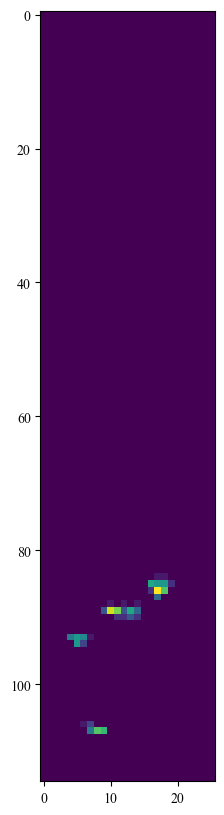

In [221]:
Td_map = Td_maps[11654]
occupation_ind = get_occupation_ind(Td_map,lane_unit_range_ranging_Tdmap,2)
image_inds = lane_image_inds[lane_ind]
image = np.zeros(image_inds.max(axis = 0) + 1)
image[image_inds[:,0],image_inds[:,1]] = occupation_ind[lane_gdf.loc[lane_gdf.lane_id == lane_ind].index]
image = image.astype(np.uint8)
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.show()

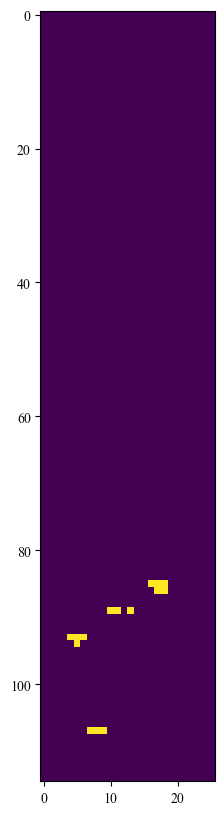

In [223]:
Td_map = Td_maps[11654]
occupation_ind = get_occupation_ind(Td_map,lane_unit_range_ranging_Tdmap,2)
image_inds = lane_image_inds[lane_ind]
image = np.zeros(image_inds.max(axis = 0) + 1)
image[image_inds[:,0],image_inds[:,1]] = occupation_ind[lane_gdf.loc[lane_gdf.lane_id == lane_ind].index]
image = image.astype(np.uint8)
plt.figure(figsize=(10, 10))
plt.imshow(image > 5)
plt.show()

In [ ]:

Td_map = Td_maps[17652]
occupation_ind = get_occupation_ind(Td_map,lane_unit_range_ranging_Tdmap,2)

# data_raw,point_labels,tracking_dic = get_foreground_point_cloud(thred_map,bck_radius,
#                                                                         Td_map,vertical_limits)
# foreground_point = data_raw[point_labels == 1]
images_all = []
for lane_ind in range(4):
    image_inds = lane_image_inds[lane_ind]
    image = np.zeros(image_inds.max(axis = 0) + 1)
    image[image_inds[:,0],image_inds[:,1]] = occupation_ind[lane_gdf.loc[lane_gdf.lane_id == lane_ind].index]
    images_all.append(image)

43.8 ms ± 338 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


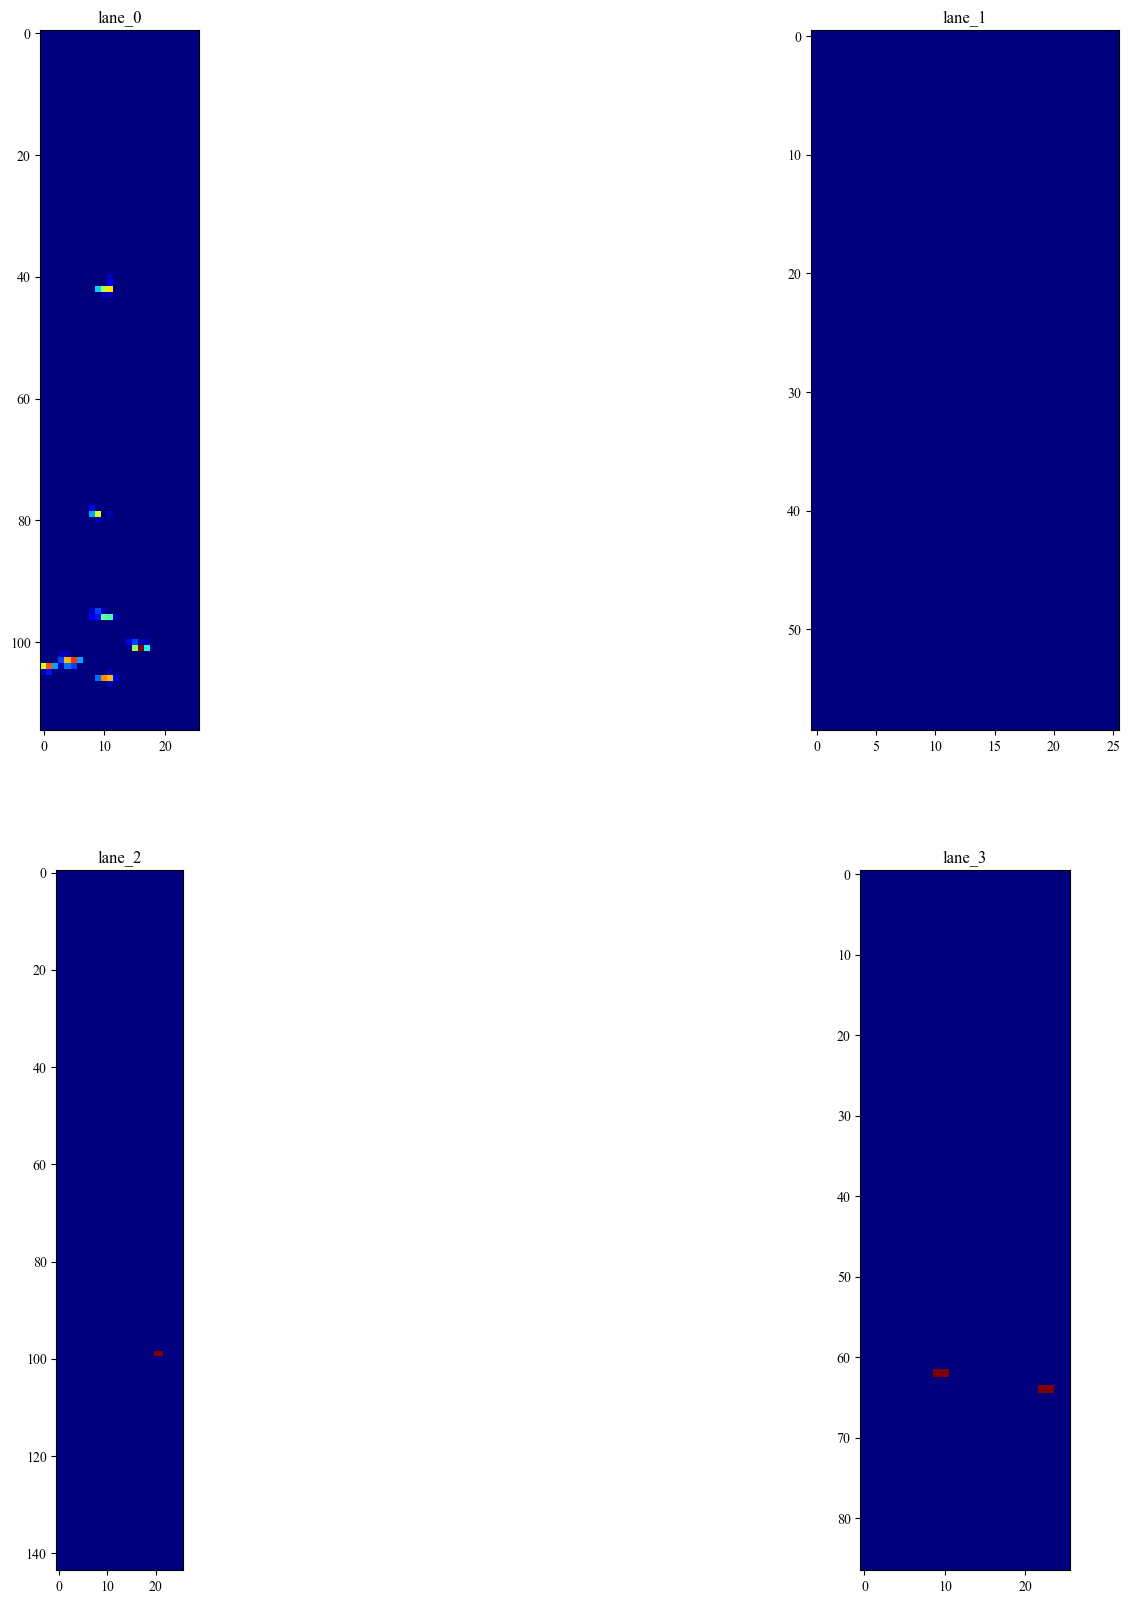

In [140]:
fig,ax = plt.subplots(2,2,figsize = (20,20))
for i in range(4):
    ax[i//2,i%2].imshow(images_all[i],cmap = 'jet')
    ax[i//2,i%2].set_title(f'lane_{i}')
plt.show()

c:\Users\zhChe\anaconda3\envs\tracking\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


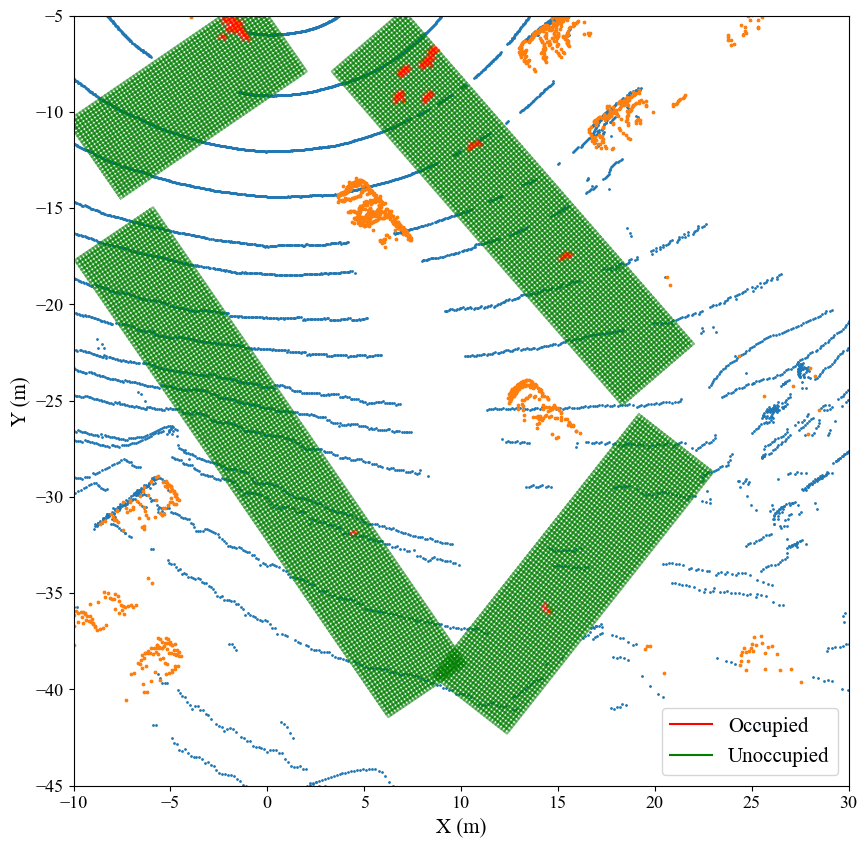

In [103]:
# plot lane_gdf, if cooresponding unit is occupied (True in occupation_ind), plot it in red, otherwise in green, also plot the foreground point cloud (data_raw)
# times new roman font is used in the plot
plt.rcParams["font.family"] = "Times New Roman"
fig,ax = plt.subplots(figsize = (10,10))
for unit_ind in range(len(lane_gdf)):
    lane_unit = lane_gdf.iloc[unit_ind]
    x_coords,y_coords = lane_unit.geometry.exterior.coords.xy
    coords = np.c_[x_coords,y_coords]
    if occupation_ind[unit_ind]:
        ax.plot(coords[:,0],coords[:,1],color = 'red',alpha = 0.5)
    else:
        ax.plot(coords[:,0],coords[:,1],color = 'green',alpha = 0.5)
    # annotation
    
ax.scatter(data_raw[:,0],data_raw[:,1],s = 1)
ax.scatter(foreground_point[:,0],foreground_point[:,1],s = 3)
# plot the x and y labels
ax.set_xlabel('X (m)',fontsize = 15)
ax.set_ylabel('Y (m)',fontsize = 15)
# plot legend 
ax.plot([0],[0],color = 'red',label = 'Occupied')
ax.plot([0],[0],color = 'green',label = 'Unoccupied')
ax.legend(fontsize = 15)
plt.xlim(-10,30)
plt.ylim(-45,-5)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
# plt.savefig('./D:\Onedrive\OneDrive - University of Nevada, Reno\Classes\CEE762\Figures\lane_occupation_state.png',dpi = 300)
plt.show()

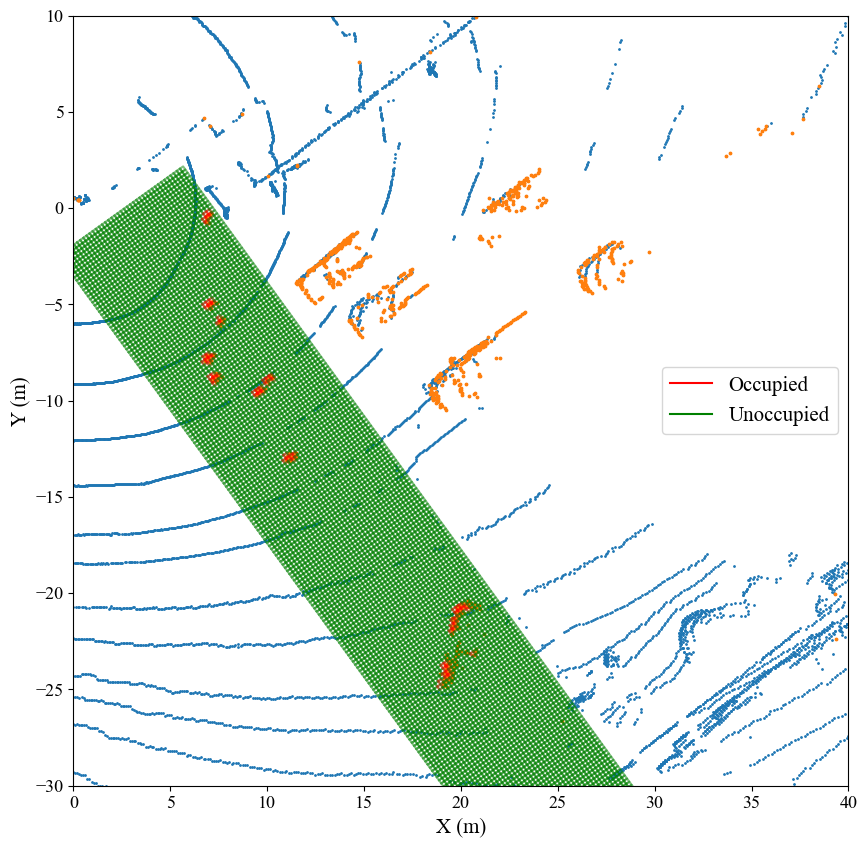

In [42]:
Td_map = Td_maps[3255]
occupation_ind = get_occupation_ind(Td_map,lane_unit_range_ranging_Tdmap,2)
occupation_ind.sum()
data_raw,point_labels,tracking_dic = get_foreground_point_cloud(thred_map,bck_radius,
                                                                        Td_map,vertical_limits)
foreground_point = data_raw[point_labels == 1]
lane_section_foreground_point_counts = get_lane_section_foreground_point_counts(lane_drawer.lane_subsections_poly,
                                                                            lane_drawer.lane_gdf,
                                                                            data_raw,point_labels)
plt.rcParams["font.family"] = "Times New Roman"
fig,ax = plt.subplots(figsize = (10,10))
for unit_ind in range(len(lane_gdf)):
    lane_unit = lane_gdf.iloc[unit_ind]
    x_coords,y_coords = lane_unit.geometry.exterior.coords.xy
    coords = np.c_[x_coords,y_coords]
    if occupation_ind[unit_ind]:
        ax.plot(coords[:,0],coords[:,1],color = 'red',alpha = 0.5)
    else:
        ax.plot(coords[:,0],coords[:,1],color = 'green',alpha = 0.5)
ax.scatter(data_raw[:,0],data_raw[:,1],s = 1)
ax.scatter(foreground_point[:,0],foreground_point[:,1],s = 3)
# plot the x and y labels
ax.set_xlabel('X (m)',fontsize = 15)
ax.set_ylabel('Y (m)',fontsize = 15)
# plot legend 
ax.plot([0],[0],color = 'red',label = 'Occupied')
ax.plot([0],[0],color = 'green',label = 'Unoccupied')
ax.legend(fontsize = 15)
plt.xlim(0,40)
plt.ylim(-30,10)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
# plt.savefig('./D:\Onedrive\OneDrive - University of Nevada, Reno\Classes\CEE762\Figures\lane_occupation_state.png',dpi = 300)
plt.show()